
<div align="center">
    <h1> Fine-tuning an LLM model use case: A Use Case in Sentiment Analysis of Crypto News  </h1>
</div>

This notebook presents a use case of fine-tuning a pre-trained LLM model to solve a downstream problem: sentiment analysis of text. The dataset used in this notebook consists of crypto news data collected over a year (from 2021-10-12 to 2023-12-19) in a structured format, including fields such as title, text, source, subject, and sentiment analysis.

The data source and description can be found at https://www.kaggle.com/datasets/oliviervha/crypto-news/data.

In [1]:
## Install python packages

# !pip install seaborn matplotlib

# !pip install datasets
# !pip install trl
# !pip install "peft==0.12"
# !pip install -q -U "accelerate" "bitsandbytes"
# !pip install huggingface_hub


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tqdm import tqdm
import torch 

from transformers import (AutoModelForCausalLM,
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline)

from peft import LoraConfig
from trl import SFTTrainer
from trl import setup_chat_format
from peft import AutoPeftModelForCausalLM


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

random_seed = 96

e:\MyWork\LLM\LLM_fine_tuning_sentiment_analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data preprocessing

### 1.1 Load data

In [2]:
data_path = './Data/cryptonews.csv'
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(31037, 7)


,date,sentiment,source,subject,text,title,url
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subjectivity': 0.6}",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the SEC needs to approve spot Bitcoin exchange-traded funds (ETFs) simultaneously.,Grayscale CEO Calls for Simultaneous Approval of Spot Products to Level the Field,https://cryptonews.comhttps://cryptonews.com/news/grayscale-ceo-calls-for-simultaneous-approval-of-spot-products-to-level-the-field.htm
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Manhar Garegrat, the Country Head for India and Global Partnerships of Liminal Custody, shares insights into crypto industry's collaborations with India government.",Indian Government is Actively Collaborating With Crypto Industry: Liminal Custody’s Country Head,https://cryptonews.comhttps://cryptonews.com/news/indian-government-is-actively-collaborating-with-crypto-industry.htm
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subjectivity': 0.05}",CryptoNews,blockchain,"According to the Federal Court ruling on December 18, former Binance CEO Changpeng 'CZ' Zhao has been ordered to pay $150 million, while Binance will pay $2.7 billion to conclude the CFTC enforcement action.","Judge Approves Settlement: Binance to Pay $1.5 Billion to CFTC, CZ to Pay $150 Million Fine",https://cryptonews.comhttps://cryptonews.com/news/judge-approves-settlement-binance-to-pay-1-5-billion-to-cftc-cz-to-pay-150-million-fine.htm
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjectivity': 0.9}",CoinTelegraph,blockchain,"Some suggest EVM inscriptions are the latest way for retail to access low-cap coins, while others argue it’s an over-hyped fad. Whatever it is, it’s clogging up the blockchain.",Why a gold rush for inscriptions has broken half a dozen blockchains,https://cointelegraph.com/news/inscriptions-evm-frenzy-clogs-up-blockchains
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censoring OFAC-sanctioned blocks has been seen as a loss for Ethereum censorship resistance.,‘Concerning precedent’ — bloXroute Labs' MEV relays to reject OFAC blocks,https://cointelegraph.com/news/concerning-precedent-bloxroute-labs-mev-relays-to-reject-ofac-blocks


### 1.2 Data cleaning

In [3]:
# Split sentiment column into "sentiment", "polarity" and "subjectivity"
df[['sentiment', 'polarity', 'subjectivity']] = df['sentiment'].str.split(',', expand=True)
df['sentiment'] = df['sentiment'].str.split(':').str[1].str.strip().str.replace("'", "")
df['polarity'] = df['polarity'].str.split(':').str[1].str.strip().astype('float')
df['subjectivity'] = df['subjectivity'].str.split(':').str[1].str.strip().str.replace("}", "").astype('float')
df.head()

,date,sentiment,source,subject,text,title,url,polarity,subjectivity
0,2023-12-19 06:40:41,negative,CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the SEC needs to approve spot Bitcoin exchange-traded funds (ETFs) simultaneously.,Grayscale CEO Calls for Simultaneous Approval of Spot Products to Level the Field,https://cryptonews.comhttps://cryptonews.com/news/grayscale-ceo-calls-for-simultaneous-approval-of-spot-products-to-level-the-field.htm,-0.10,0.60
1,2023-12-19 06:03:24,neutral,CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Manhar Garegrat, the Country Head for India and Global Partnerships of Liminal Custody, shares insights into crypto industry's collaborations with India government.",Indian Government is Actively Collaborating With Crypto Industry: Liminal Custody’s Country Head,https://cryptonews.comhttps://cryptonews.com/news/indian-government-is-actively-collaborating-with-crypto-industry.htm,0.00,0.00
2,2023-12-19 05:55:14,positive,CryptoNews,blockchain,"According to the Federal Court ruling on December 18, former Binance CEO Changpeng 'CZ' Zhao has been ordered to pay $150 million, while Binance will pay $2.7 billion to conclude the CFTC enforcement action.","Judge Approves Settlement: Binance to Pay $1.5 Billion to CFTC, CZ to Pay $150 Million Fine",https://cryptonews.comhttps://cryptonews.com/news/judge-approves-settlement-binance-to-pay-1-5-billion-to-cftc-cz-to-pay-150-million-fine.htm,0.05,0.05
3,2023-12-19 05:35:26,positive,CoinTelegraph,blockchain,"Some suggest EVM inscriptions are the latest way for retail to access low-cap coins, while others argue it’s an over-hyped fad. Whatever it is, it’s clogging up the blockchain.",Why a gold rush for inscriptions has broken half a dozen blockchains,https://cointelegraph.com/news/inscriptions-evm-frenzy-clogs-up-blockchains,0.50,0.90
4,2023-12-19 05:31:08,neutral,CoinTelegraph,ethereum,A decision by bloXroute Labs to start censoring OFAC-sanctioned blocks has been seen as a loss for Ethereum censorship resistance.,‘Concerning precedent’ — bloXroute Labs' MEV relays to reject OFAC blocks,https://cointelegraph.com/news/concerning-precedent-bloxroute-labs-mev-relays-to-reject-ofac-blocks,0.00,0.00


In [4]:
# Numerical variables
df.describe()

,polarity,subjectivity
count,31037.000000,31037.000000
mean,0.063841,0.337602
std,0.196266,0.269906
min,-1.000000,0.000000
25%,0.000000,0.080000
50%,0.000000,0.330000
75%,0.150000,0.500000
max,1.000000,1.000000


In [5]:
# String and categorical variables
df.describe(include='object')

,date,sentiment,source,subject,text,title,url
count,31037,31037,31037,31037,31037,31037,31037
unique,30497,3,3,6,30423,30964,31037
top,2022-01-14 00:00:00,positive,CoinTelegraph,bitcoin,"Get your daily, bite-sized digest of cryptoasset and blockchain-related news.",Is it Too Late to Buy Shiba Inu? Crypto Experts Give Their SHIB Price Predictions,https://cryptonews.com/news/celo-to-be-fastest-evm-chain-by-end-of-2022-co-founder-says.htm
freq,26,13964,13010,9968,447,4,1


In [6]:
# Check Nan values
df.isna().sum()

date            0
sentiment       0
source          0
subject         0
text            0
title           0
url             0
polarity        0
subjectivity    0
dtype: int64

In [8]:
# Filter out duplicated text
print(f"Duplicated text: {df['text'].duplicated().sum()} samples")
df_cleaned = df.drop_duplicates(subset='text', keep='first')

Duplicated text: 614 samples


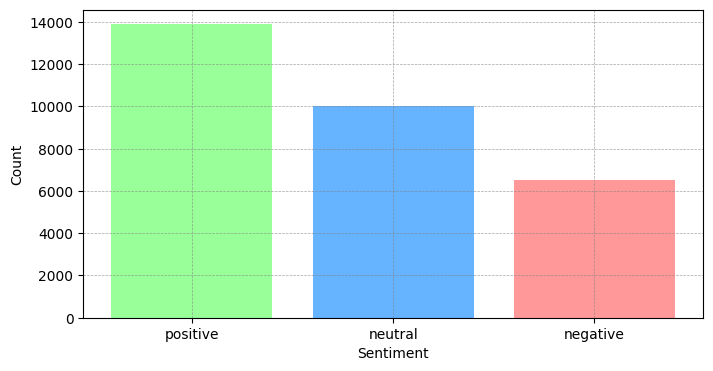

In [9]:
# Statistics
fig, ax = plt.subplots(figsize=(8, 4))
plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
counts = df_cleaned["sentiment"].value_counts()
colors = counts.index.map({"positive": "#99ff99", "negative": "#ff9999", "neutral": "#66b3ff"})
ax.bar(counts.index, counts.values, color=colors)
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
plt.savefig('./Figs/hist_data_all_sentiment.png')

In [10]:
list_subjects = list(df_cleaned['subject'].unique())
list_category_counts = []
for subject in list_subjects:
    sub_df = df_cleaned[df_cleaned['subject'] == subject]
    list_category_counts.append(sub_df['sentiment'].value_counts())
    

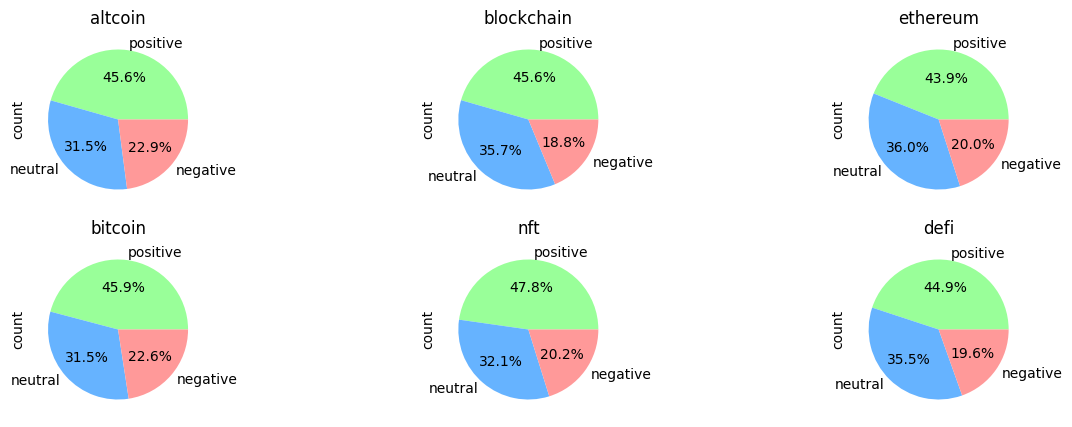

In [11]:
# Create a figure with one subplot for each subject
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

axes = axes.flatten()

for i in range(len(list_subjects)):
    ax = axes[i]
    ax.set_title(list_subjects[i])
    # Plot pie chart
    list_category_counts[i].plot(ax = ax, kind='pie', autopct='%1.1f%%', colors=['#99ff99', '#66b3ff','#ff9999'])
    plt.gca().set_aspect('equal')
    
# Show the plot
plt.savefig('./Figs/pieplot_sentiment_by_coin.png')
plt.show()

### 1.3 Featrure selection

For this sentiment analysis task, we will use the title and content ('text' column) of the news  to predict the sentiment as positive, neutral, or negative.

In [12]:
crypto_df  = df_cleaned[['text', 'title', 'sentiment']]
crypto_df = crypto_df.reset_index(drop=True)

### 1.4 Preparing data for LLM

In [13]:
train_list = []
valid_list = []
test_list = []
for sentiment in ["positive", "neutral", "negative"]:
    train, test_tmp  = train_test_split(crypto_df[crypto_df['sentiment']==sentiment], test_size=0.2, random_state=random_seed)
    valid, test = train_test_split(test_tmp, test_size=0.2, random_state=random_seed)

    # train, test_tmp  = train_test_split(crypto_df[crypto_df['sentiment']==sentiment], train_size=1000,      # Extract a small dataset to test
    #                                     test_size=400, random_state=random_seed)
    # valid, test = train_test_split(test_tmp, test_size=0.2, random_state=random_seed)
    
    train_list.append(train)
    valid_list.append(valid)
    test_list.append(test)

train_df = pd.concat(train_list).sample(frac=1, random_state=random_seed).reset_index(drop=True)
valid_df = pd.concat(valid_list).sample(frac=1, random_state=random_seed).reset_index(drop=True)
test_df = pd.concat(test_list).sample(frac=1, random_state=random_seed).reset_index(drop=True)

def generate_prompt(data_point):
    return f""" 
            Title: {data_point["title"]}]
            Text: {data_point["text"]}]
            Constraints: Generate the label from "positive" or "negative" or "neutral" with the delimiter "Prediction".
            Prediction= {data_point["sentiment"]}
            """.strip()

def generate_test_prompt(data_point):
    return f""" 
            Title: {data_point["title"]}]
            Text: {data_point["text"]}]
            Constraints: Generate the label from "positive" or "negative" or "neutral" with the delimiter "Prediction".
            Prediction= 
            """.strip()

X_train = pd.DataFrame(train_df.apply(generate_prompt, axis=1), 
                       columns=["text"])
X_valid = pd.DataFrame(valid_df.apply(generate_prompt, axis=1), 
                      columns=["text"])

y_true = test_df['sentiment']
X_test = pd.DataFrame(test_df.apply(generate_test_prompt, axis=1), columns=["text"])

train_data = Dataset.from_pandas(X_train)
valid_data = Dataset.from_pandas(X_valid)
print(train_data.shape)
print(valid_data.shape)

(24337, 1)
(4868, 1)


## 2. Model fine tunning

### 2.1. Load pre-trained model

In [71]:
# Llama-3.2-1B in a gated model, Create an account and use access token to get model from Fugging Face
from huggingface_hub import notebook_login

notebook_login()

In [60]:
# Load LLM pre-trained model from Hugging Face (https://huggingface.co/models)
# model_name = "openai-community/gpt2-large"
model_name="meta-llama/Llama-3.2-1B"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, 
    bnb_4bit_quant_type="nf4", 
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

# Load model
model = AutoModelForCausalLM.from_pretrained( 
    model_name,
    device_map=device,
    trust_remote_code=True,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({"pad_token":"<pad>"})
tokenizer.padding_side = "right"

# Sets up model and tokenizer for conversational AI tasks (https://huggingface.co/docs/trl/sft_trainer)
model, tokenizer = setup_chat_format(model, tokenizer)

### 2.2. Setup functions for prediction and evaluation

In [14]:
def predict(model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens = 1, 
                        temperature = 0.001,
                       )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("=")[-1].lower()
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred


def eval(y_true, y_pred):
    y_pred = [i if i != 'none' else 'neutral' for i in y_pred]
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = ['positive','neutral','negative']  

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) 
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred, labels=unique_labels)
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred,labels=unique_labels)
    print('\nConfusion Matrix:')
    print(conf_matrix)
    return conf_matrix, unique_labels

### 2.3. Test pre-trained model

In [62]:
prompt = X_test.iloc[0]["text"]
pipe = pipeline(task="text-generation", 
                model=model, 
                tokenizer=tokenizer, 
                max_new_tokens = 1, 
                temperature = 0.001,
                )
result = pipe(prompt)
result

[{'generated_text': 'Title: SBF Willing to Testify Before US House Committee of Financial Services Next Week]\n            Text: Bankman-Fried promised to testify before the US House Committee on Financial Services on December 13.]\n            Constraints: Generate the label from "positive" or "negative" or "neutral" with the delimiter "Prediction".\n            Prediction=Positive'}]

In [63]:
y_pred = predict(model, tokenizer)
conf_matrix, unique_labels = eval(y_true, y_pred)

100%|██████████| 1218/1218 [02:32<00:00,  7.98it/s]

Accuracy: 0.438
Accuracy for label positive: 0.872
Accuracy for label neutral: 0.122
Accuracy for label negative: 0.000

Classification Report:
              precision    recall  f1-score   support

    positive       0.46      0.87      0.60       556
     neutral       0.31      0.12      0.17       401
    negative       0.00      0.00      0.00       261

    accuracy                           0.44      1218
   macro avg       0.26      0.33      0.26      1218
weighted avg       0.31      0.44      0.33      1218


Confusion Matrix:
[[485  71   0]
 [352  49   0]
 [222  39   0]]


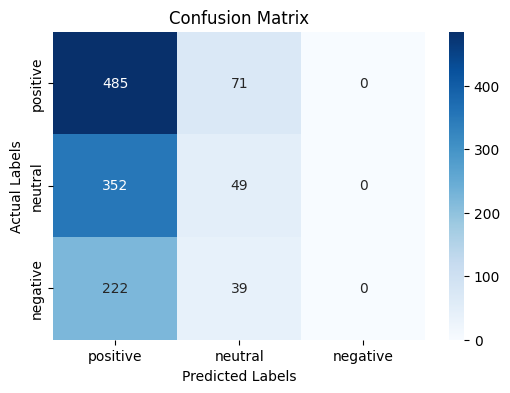

In [66]:
# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.savefig('./Figs/pretrained_Llama3-2_confusion_matrix.png')
plt.show()

### 2.4. Fine-tuning LLM model

In [20]:
# Setup training configuration and arguments

output_dir="trained_weights/llama3-2"

peft_config = LoraConfig(
        lora_alpha=16, 
        lora_dropout=0.1,
        r=32,
        bias="none",
        # target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
        target_modules="all-linear",
        task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=5,                       # number of training epochs
    per_device_train_batch_size=8,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,                         # log every 10 steps
    learning_rate=5e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=True,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="tensorboard",                  # report metrics to tensorboard
    evaluation_strategy="epoch"               # save checkpoint every epoch
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=valid_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=1024,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    }
)

Map:   0%|          | 0/24337 [00:00<?, ? examples/s]

Map:   0%|          | 0/4868 [00:00<?, ? examples/s]

In [21]:
# Train model
trainer.train()

  0%|          | 0/1900 [00:00<?, ?it/s]

{'loss': 2.9288, 'grad_norm': 0.7130488753318787, 'learning_rate': 0.0002192982456140351, 'epoch': 0.07}
{'loss': 1.6969, 'grad_norm': 0.3014258146286011, 'learning_rate': 0.0004385964912280702, 'epoch': 0.13}
{'loss': 1.7821, 'grad_norm': 0.22245225310325623, 'learning_rate': 0.0004998823288423862, 'epoch': 0.2}
{'loss': 1.6307, 'grad_norm': 0.26121652126312256, 'learning_rate': 0.0004993287233374406, 'epoch': 0.26}
{'loss': 1.7257, 'grad_norm': 0.23751036822795868, 'learning_rate': 0.0004983223915795511, 'epoch': 0.33}
{'loss': 1.6065, 'grad_norm': 0.23085658252239227, 'learning_rate': 0.0004968651608463767, 'epoch': 0.39}
{'loss': 1.7029, 'grad_norm': 0.24057169258594513, 'learning_rate': 0.000494959677149178, 'epoch': 0.46}
{'loss': 1.5925, 'grad_norm': 0.2487366646528244, 'learning_rate': 0.0004926094004282407, 'epoch': 0.53}
{'loss': 1.6943, 'grad_norm': 0.235698401927948, 'learning_rate': 0.0004898185982703836, 'epoch': 0.59}
{'loss': 1.5693, 'grad_norm': 0.2406596690416336, 'le

  0%|          | 0/609 [00:00<?, ?it/s]

{'eval_loss': 1.616281509399414, 'eval_runtime': 642.4418, 'eval_samples_per_second': 7.577, 'eval_steps_per_second': 0.948, 'epoch': 1.0}
{'loss': 1.522, 'grad_norm': 0.2390987128019333, 'learning_rate': 0.00045847210887295056, 'epoch': 1.05}
{'loss': 1.4877, 'grad_norm': 0.25849854946136475, 'learning_rate': 0.0004524044343054709, 'epoch': 1.12}
{'loss': 1.4916, 'grad_norm': 0.2683020532131195, 'learning_rate': 0.0004459692376976269, 'epoch': 1.18}
{'loss': 1.4899, 'grad_norm': 0.27480217814445496, 'learning_rate': 0.0004391782039544238, 'epoch': 1.25}
{'loss': 1.5012, 'grad_norm': 0.27065929770469666, 'learning_rate': 0.0004320436641030253, 'epoch': 1.31}
{'loss': 1.4782, 'grad_norm': 0.2852303087711334, 'learning_rate': 0.0004245785729023143, 'epoch': 1.38}
{'loss': 1.4824, 'grad_norm': 0.2692306339740753, 'learning_rate': 0.0004167964853198931, 'epoch': 1.45}
{'loss': 1.4837, 'grad_norm': 0.2728515565395355, 'learning_rate': 0.0004087115319192367, 'epoch': 1.51}
{'loss': 1.4814, '

  0%|          | 0/609 [00:00<?, ?it/s]

{'eval_loss': 1.572167158126831, 'eval_runtime': 575.26, 'eval_samples_per_second': 8.462, 'eval_steps_per_second': 1.059, 'epoch': 2.0}
{'loss': 1.3807, 'grad_norm': 0.29923656582832336, 'learning_rate': 0.00033499314486749014, 'epoch': 2.04}
{'loss': 1.3085, 'grad_norm': 0.32639607787132263, 'learning_rate': 0.00032489980224670653, 'epoch': 2.1}
{'loss': 1.2931, 'grad_norm': 0.30346912145614624, 'learning_rate': 0.0003146704580198362, 'epoch': 2.17}
{'loss': 1.3127, 'grad_norm': 0.3539654612541199, 'learning_rate': 0.00030432368643143454, 'epoch': 2.23}
{'loss': 1.2839, 'grad_norm': 0.32007691264152527, 'learning_rate': 0.0002938782749483789, 'epoch': 2.3}
{'loss': 1.3205, 'grad_norm': 0.3480469286441803, 'learning_rate': 0.0002833531901459516, 'epoch': 2.37}
{'loss': 1.2817, 'grad_norm': 0.3290998637676239, 'learning_rate': 0.00027276754326870025, 'epoch': 2.43}
{'loss': 1.3165, 'grad_norm': 0.3335193395614624, 'learning_rate': 0.0002621405555286121, 'epoch': 2.5}
{'loss': 1.2739, '

  0%|          | 0/609 [00:00<?, ?it/s]

{'eval_loss': 1.5828145742416382, 'eval_runtime': 1168.0278, 'eval_samples_per_second': 4.168, 'eval_steps_per_second': 0.521, 'epoch': 3.0}
{'loss': 1.2165, 'grad_norm': 0.3531627357006073, 'learning_rate': 0.0001779514997319085, 'epoch': 3.02}
{'loss': 1.1221, 'grad_norm': 0.37241995334625244, 'learning_rate': 0.0001678182180298052, 'epoch': 3.09}
{'loss': 1.0872, 'grad_norm': 0.38403066992759705, 'learning_rate': 0.0001578341604111272, 'epoch': 3.15}
{'loss': 1.1342, 'grad_norm': 0.3797492980957031, 'learning_rate': 0.00014801745573377097, 'epoch': 3.22}
{'loss': 1.0866, 'grad_norm': 0.3954198658466339, 'learning_rate': 0.0001383859289794126, 'epoch': 3.29}
{'loss': 1.1397, 'grad_norm': 0.44085556268692017, 'learning_rate': 0.0001289570688872527, 'epoch': 3.35}
{'loss': 1.0917, 'grad_norm': 0.4112408459186554, 'learning_rate': 0.00011974799619830293, 'epoch': 3.42}
{'loss': 1.1359, 'grad_norm': 0.398465096950531, 'learning_rate': 0.00011077543256787745, 'epoch': 3.48}
{'loss': 1.074

KeyboardInterrupt: 

In [22]:
# Save trained model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('trained_weigths/llama3-2_5epochs\\tokenizer_config.json',
 'trained_weigths/llama3-2_5epochs\\special_tokens_map.json',
 'trained_weigths/llama3-2_5epochs\\tokenizer.json')

In [37]:
!kill 15056

'kill' is not recognized as an internal or external command,
operable program or batch file.


In [36]:
%load_ext tensorboard
%tensorboard --logdir trained_weights/llama3-2/runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6010 (pid 15056), started 19:02:13 ago. (Use '!kill 15056' to kill it.)

### 2.5. Evaluating fine-tuned model

In [16]:
# model_name = "openai-community/gpt2-large"
model_name="meta-llama/Llama-3.2-1B"
finetuned_model = "trained_weights/llama3-2"
compute_dtype = getattr(torch, "float16")
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({"pad_token":"<pad>"})
tokenizer.padding_side = "right"

model = AutoPeftModelForCausalLM.from_pretrained(
     finetuned_model,
     torch_dtype=compute_dtype,
     return_dict=False,
     low_cpu_mem_usage=True,
     device_map=device,
)

merged_model = model.merge_and_unload()

In [17]:
y_pred = predict(merged_model, tokenizer)

  0%|          | 0/1218 [00:00<?, ?it/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
100%|██████████| 1218/1218 [01:54<00:00, 10.59it/s]


In [43]:
confusion_matrix, unique_labels = eval(y_true, y_pred)

Accuracy: 0.822
Accuracy for label positive: 0.905
Accuracy for label neutral: 0.863
Accuracy for label negative: 0.582

Classification Report:
              precision    recall  f1-score   support

    positive       0.84      0.90      0.87       556
     neutral       0.81      0.86      0.83       401
    negative       0.79      0.58      0.67       261

    accuracy                           0.82      1218
   macro avg       0.81      0.78      0.79      1218
weighted avg       0.82      0.82      0.82      1218


Confusion Matrix:
[[503  32  21]
 [ 36 346  19]
 [ 58  51 152]]


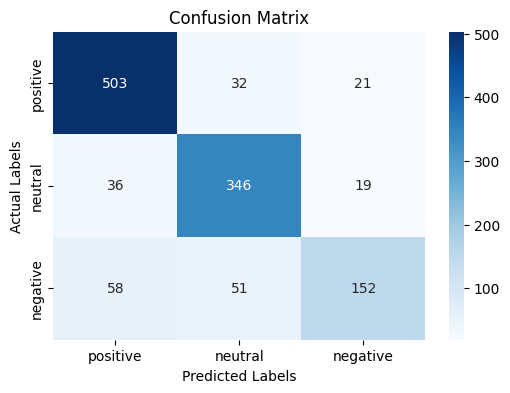

In [44]:
# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.savefig('./Figs/Llama3-2_confusion_matrix.png')
plt.show()

In [19]:
i = 99
prompt = X_test.iloc[i]["text"]
pipe = pipeline(task="text-generation", 
                model=merged_model, 
                tokenizer=tokenizer, 
                max_new_tokens = 1, 
                temperature = 0.001,
                )
result = pipe(prompt)
print(result)
print(f"True label: {y_true[i]}")

[{'generated_text': 'Title: Spot Bitcoin ETF Application Approvals Likely By January 10th, JPMorgan Argues \\x93 How High Can the BTC Price Pump in 2024?]\n            Text: Spot Bitcoin ETF approvals could be one of a few key bullish drivers for the BTC price next year.]\n            Constraints: Generate the label from "positive" or "negative" or "neutral" with the delimiter "Prediction".\n            Prediction= negative'}]
True label: negative


In [28]:
false_positive = [i for i in range(len(y_true)) if y_pred[i]=='positive' and y_true[i]=='negative']
print(len(false_positive))
test_df.loc[false_positive]

58


,text,title,sentiment
26,The market frenzy that started with the Silicon Valley Bank collapse is pushing BTC price higher but with some casualties left behind.,Bitcoin price flash spikes to $50K on Binance after USD Coin peg snaps,negative
40,"War fears do Bitcoin and altcoins no favors, with losses coming thick and fast followed by a modest recovery.",Bitcoin rises above $36K as 24-hour crypto liquidations pass $500M,negative
42,Exploring the conflict between the SEC and major cryptocurrency corporations and the fight for investor protection in digital currency markets.,Cryptocurrency versus the SEC: A fight for fair digital investing,negative
67,AI-powered market analytics and intelligence tool helps Web3 users to avoid fake NFTs and estimate the real value of tokens.,The NFT market needs AI power to combat forgery and inflation,negative
85,Ripple's CTO and the well-known XRP attorney John Deaton shared some thought as to when the ruling in the case against the SEC might come.,When Will The Ripple-SEC Ruling Come? XRP CTO and Known Attorney Speculate on a Deadline,negative
100,"Former Binance CEO Changpeng Zhao, commonly known as CZ, is still worth $15 billion despite recently pleading guilty to federal money laundering charges.",Former Binance CEO Changpeng Zhao Still Worth $15 Billion Despite Guilty Plea: Forbes,negative
156,A new report suggests that a notorious North Korea-affiliated hacking group may be behind last week’s $100 million Harmony attack.,Infamous North Korean hacker group identified as suspect for $100M Harmony attack,negative
172,Lawyers representing Binance in its battle against the Securities and Exchange Commission have made a startling revelation.,Binance Lawyers Claim Gensler Offered to be Company Advisor,negative
175,"The firm reported it held 174,530 Bitcoin as of Nov. 29 — worth roughly $6.6 billion at a price of $37,726.",Bitcoin for Christmas: MicroStrategy buys another $600M,negative
195,"The firm warned that If an Apple user has enabled automatic iCloud backups of their MetaMask wallet data, their seed phrase is being stored online.",MetaMask warns Apple users over iCloud phishing attacks,negative


In [29]:
false_negative = [i for i in range(len(y_true)) if y_pred[i]=='negative' and y_true[i]=='positive']
print(len(false_negative))
test_df.loc[false_negative]

21


,text,title,sentiment
73,The cryptocurrency has grown tremendously in the past couple of years in terms of valuations but also in terms of adoption. From institutions jumping on the Bitcoin bandwagon to retail,Go+ Security Engine: Solving Everpresent Security Issues in the Crypto Industry,positive
74,Recovering stolen Bitcoin from crypto scams is challenging due to the anonymous nature of blockchain transactions and jurisdictional issues.,Can you recover stolen Bitcoin from crypto scams?,positive
91,The price of YFI and other projects where Andre Cronje was involved plunged today after reports of him leaving the industry for good.,Yearn Finance (YFI) Plunges 13% on Reports of Andre Cronje Leaving Crypto,positive
97,"Anthony Hopkins, a Welsh actor, director, and producer, has seen his first NFT collection sold out in less than 10 minutes.",Anthony Hopkins NFT Sells-Out in 7 Minutes \x93 Here's Everything You Need to Know,positive
145,Deus Finance DAO seems to have lost at least USD 13m in its latest flashloan attack.,"Deus DAO Exploited Again, Loses Reported USD 13M+ in Flashloan Attack",positive
180,"A $53-million exposure to Babel and Celsius left the South-East Asian trading platform with an acute liquidity crisis, forcing it to halt withdrawals last month.\xa0\xa0",Singapore High Court Grants Troubled Zipmex 3-Month Relief From Creditors: Report,positive
186,1inch Network (1INCH) has seen a spectacular pump and dump in the past 2 days. Here's where it could be headed next.,1inch Network Price Prediction as 1INCH Dumps 15% - Is a Whale Selling?,positive
235,"Sentiment in the crypto market improved markedly over the past week, with the 7-day sentscores of both of the two largest cryptoassets now back in positive territory, according to the market sentiment analysis service Omenics.","Sentiment Improves as Bitcoin, Ethereum Jump into Positive Territory",positive
345,Twitter's new rate limits have severely affected the indexing and display of tweets onÂ\xa0Google's search engine.,Rate Limit Cut on Twitter to Diminish Crypto Visibility on Google,positive
410,"Shiba Inu price is up a colossal 50% from December lows of $0.00000774, although the meme token's recovery reached January highs of $0.00001292 last week. Investors appear to be shifting their attention to the second-largest...",Shiba Inu Price Prediction as $300 Million Trading Volume Comes In \x93 Are Whales Buying SHIB?,positive
